# Dueling Deep Q Network

## Imports

In [1]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

from timeit import default_timer as timer
from datetime import timedelta
import math

from utils.wrappers import *
from agents.DQN import Model as DQN_Agent
from utils.ReplayMemory import ExperienceReplayMemory

from utils.hyperparameters import Config

## Hyperparameters

In [2]:
config = Config()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#epsilon variables
config.epsilon_start = 1.0
config.epsilon_final = 0.01
config.epsilon_decay = 30000
config.epsilon_by_frame = lambda frame_idx: config.epsilon_final + (config.epsilon_start - config.epsilon_final) * math.exp(-1. * frame_idx / config.epsilon_decay)

#misc agent variables
config.GAMMA=0.99
config.LR=1e-4

#memory
config.TARGET_NET_UPDATE_FREQ = 1000
config.EXP_REPLAY_SIZE = 100000
config.BATCH_SIZE = 32

#Learning control variables
config.LEARN_START = 10000
config.MAX_FRAMES=1000000

#Nstep controls
config.N_STEPS=1

## Network

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, input_shape, num_outputs):
        super(DuelingDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_outputs
        
        self.conv1 = nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        self.adv1 = nn.Linear(self.feature_size(), 512)
        self.adv2 = nn.Linear(512, self.num_actions)

        self.val1 = nn.Linear(self.feature_size(), 512)
        self.val2 = nn.Linear(512, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)

        adv = F.relu(self.adv1(x))
        adv = self.adv2(adv)

        val = F.relu(self.val1(x))
        val = self.val2(val)

        return val + adv - adv.mean()
    
    def feature_size(self):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *self.input_shape)))).view(1, -1).size(1)
    
    def sample_noise(self):
        #ignore this for now
        pass

## Agent

In [4]:
class Model(DQN_Agent):
    def __init__(self, static_policy=False, env=None, config=None):
        super(Model, self).__init__(static_policy, env, config)

    def declare_networks(self):
        self.model = DuelingDQN(self.env.observation_space.shape, self.env.action_space.n)
        self.target_model = DuelingDQN(self.env.observation_space.shape, self.env.action_space.n)

## Plot Results

In [5]:
def plot(frame_idx, rewards, losses, sigma, elapsed_time):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s. time: %s' % (frame_idx, np.mean(rewards[-10:]), elapsed_time))
    plt.plot(rewards)
    if losses:
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
    if sigma:
        plt.subplot(133)
        plt.title('noisy param magnitude')
        plt.plot(sigma)
    plt.show()

## Training Loop

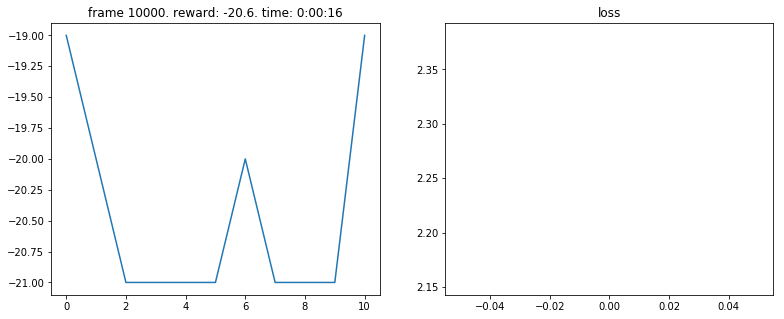

In [ ]:
start=timer()

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, frame_stack=False)
env    = wrap_pytorch(env)
model = Model(env=env, config=config)

episode_reward = 0

observation = env.reset()
for frame_idx in range(1, config.MAX_FRAMES + 1):
    epsilon = config.epsilon_by_frame(frame_idx)

    action = model.get_action(observation, epsilon)
    prev_observation=observation
    observation, reward, done, _ = env.step(action)
    observation = None if done else observation

    model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward

    if done:
        model.finish_nstep()
        model.reset_hx()
        observation = env.reset()
        model.save_reward(episode_reward)
        episode_reward = 0
        
        if np.mean(model.rewards[-10:]) > 19:
            plot(frame_idx, all_rewards, losses, timedelta(seconds=int(timer()-start)))
            break

    if frame_idx % 10000 == 0:
        plot(frame_idx, model.rewards, model.losses, model.sigma_parameter_mag, timedelta(seconds=int(timer()-start)))

model.save_w()
env.close()